# 発展課題

**対象：優上を希望する、理学部提供科目の履修生**

「音情報解析」「自然言語処理・トピック分析」「画像処理・画像認識」「WebスクレイピングとAPI」の４つの分野のうち、２つ以上の分野を含むプログラムを作って、Jupyter notebook（ipynbファイル）として提出してください。

- コードは教材あるいは課題ファイルに含まれているものをベースにしてください。演習にも教材にも含まれていないコードが大半を占めるプログラムは評価しません。
- コードだけではなく、プログラムの解説文を記載してください。プログラムの目的は何で、どのような手法で解決したのか、どうやって実行するのか、どのようなページや本を参考としたかといった解説を簡潔に書いてください。説明が分かりづらい場合は減点の対象となります（無駄に長くしないでください）。
- こちらで実行して動作を検証できるようなプログラムを作ってください。ただし、WebAPIを使用する場合は、実行結果が出ている状態で保存したファイルで評価するので、**API Key等、第三者に渡してはならないコードは削除して提出**してください。
- 外部ファイルを入力とする場合は、２ファイルまで添付してもいいものとします（**合計１０MBまでにしてください。また、著作権を侵害しないよう注意してください**）。
- 友達と相談するのは構いませんが、複数名で似たプログラムを提出しないでください。コードが似ていると判断したものは減点の対象とします
- **皆さんのアイディアを評価します**

※ 提出されたプログラムの中で特に優れたものは、個人情報を削除し、私のほうで書き換えた上で、次回以降の講義で受講生の参考にさせていただきたいと思います。もしこのような使い方をされたくない場合は、この下に太赤字で「公開不可」と記入してください。

# 解説

プログラムの目的：マイナーな料理の画像を見て、その料理名を選択肢の中から正しく選択すること。

手法：まず、CLIPを用いて画像と料理名リストの各要素との類似度を計算し、その中で最も確率が高い料理名を予測結果とした。この方法でも多くの料理に関しては正しく予測できるのだが、以下のコードで示すように、インドネシア料理「Mie ayam」について間違った予測結果を生んでしまった。これは、「Mie ayam」に関する情報が学習データにおいてあまり重視されていなかったためであると考えられる。そこで、料理名のwikipedia記事をスクレイピングすることでその料理に関する説明を得て、料理名のリストの代わりに料理の説明文のリストをCLIPに渡すことで正しく予測できるのではないかと考えた。ただしCLIPの入力テキストには長さの制限があるため、スクレイピング結果をBERTを用いて要約してからCLIPに渡すことにした。その手法によって、大幅に予測精度を改善することができた。

外部ファイル：UTOLにて添付のimage.jpg（インドネシア料理Mie ayamのフリー画像。https://www.photo-ac.com より取得した。）

実行方法：image.jpgを作業ディレクトリ直下に置き、全セルを実行。Google Colabのデフォルト環境でパッケージのインストールを含め約6分で実行できる。パッケージが正しくインストールされていれば、ローカルでも実行できる。

参考：
「自然言語処理・トピック分析」「画像処理・画像認識」「WebスクレイピングとAPI」の3分野から、以下の教材のコードを参考にした。
- ImageRecognition4.ipynb（画像認識4：CLIP）
- WebDataProcessing1.ipynb（ウェブデータ処理１: ウェブスクレイピング）
- TopicAnalysis4.ipynb（トピック分析４：事前学習済みの日本語BERTで様々なタスクを解いてみよう!）

In [1]:
# コードはこちらに書いてください。
import sys
if 'google.colab' in sys.modules:
    # for img processing
    !pip install transformers
    !pip install accelerate --upgrade
    !pip install pillow

    # for bert
    !pip install fugashi
    !pip install unidic-lite
    !pip install ipadic
    !pip install sentencepiece==0.1.94 ## 再起動が必要になるもの
    !pip install sacremoses

In [2]:
# 料理名の選択肢
dish_name_options = [
    "Fried rice",
    "Mie ayam",
    "Bibimbap",
    "Rendang",
    "Janchi Guksu",
    "Nasi goreng",
    "Poutine"
]

In [3]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/Users/ryoma/anaconda3/envs/py39env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


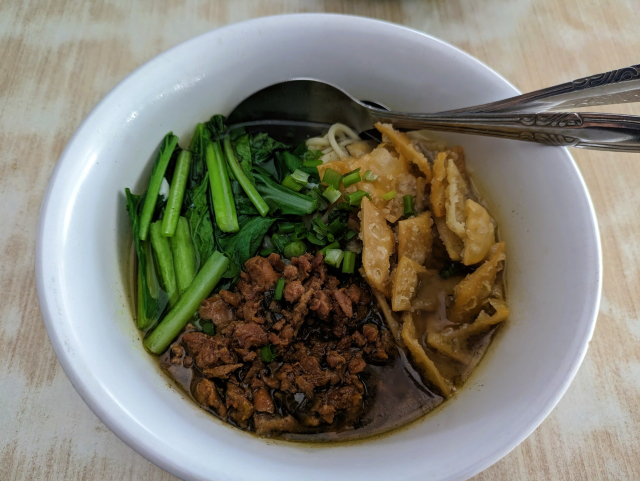

In [4]:
from PIL import Image

image_url = "image.jpg" 
image = Image.open(image_url)
image

In [5]:
# ref: ImageRecognition4.ipynb

import numpy as np

inputs = processor(
    text=dish_name_options,
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print(
    "Prediction:",
    dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Janchi Guksu

Fried rice: 0.1%
Mie ayam: 27.0%
Bibimbap: 3.6%
Rendang: 21.4%
Janchi Guksu: 44.7%
Nasi goreng: 3.1%
Poutine: 0.0%


## 実際はMie ayamの画像だが、Janchi Guksuと予想された。

なお、Janchi Guksuの画像を入れると、正しくJanchi Guksuと予想された。フリー画像ではないのでここでは示さないが、興味があればこちらから。
- https://jp.123rf.com/photo_113779078_%E3%82%B8%E3%83%A3%E3%83%B3%E3%83%81%E9%BA%BA%E3%80%81%E3%82%A2%E3%83%B3%E3%83%81%E3%83%A7%E3%83%93%E3%83%9F%E3%83%BC%E3%83%88%E3%83%96%E3%83%AD%E3%82%B9%E3%81%AE%E9%9F%93%E5%9B%BD%E9%BA%BA%E6%96%99%E7%90%86.html

In [6]:
# ref: WebDataProcessing1.ipynb

import requests
from bs4 import BeautifulSoup
from time import sleep

dish_wikis = []

for dish_name in dish_name_options:
    # wikiの命名規則に沿って、スペースをアンダースコアに置換
    dish_name = dish_name.replace(" ", "_")
    url = f"https://en.wikipedia.org/wiki/{dish_name}"

    res = requests.get(url)
    res.encoding = res.apparent_encoding  # 文字コードを設定
    soup = BeautifulSoup(res.text, "lxml")

    # mw-body-contentクラスは1個しかないので、find_allでも1個のリストになる
    for item in soup.find_all("div", attrs={"class": "mw-body-content"}):
        dish_wikis.append(item.text.replace("\n", " "))

    sleep(10) # 連続してアクセスしないよう、10秒待機

# 数が一致しているか確認
print(len(dish_wikis) == len(dish_name_options))

True


In [7]:
# 中身の確認
dish_wikis[1]

'Indonesian chicken noodle dish Bakmi ayamBakmi ayam with mushroom, chinese cabbage and chicken broth soup.Alternative namesMi ayam cincang, bakmi ayam,  Chicken noodlesCourseMain coursePlace of originIndonesia[1]Region or stateNationwideAssociated cuisineIndonesiaServing temperatureHotMain ingredientsNoodle, chicken meat, soy sauce, garlic, cooking oil (from chicken fat or vegetable oil), chicken broth, chinese cabbage, scallionsFood energy(per serving)1 bowl of mie ayam contains 500 calories.[2]\xa0kcal\xa0 Media: Bakmi ayam Mie ayam, mi ayam, or bakmi ayam (Indonesian for \'chicken bakmi\', literally \'chicken noodles\') is a common Indonesian dish of seasoned yellow wheat noodles topped with diced chicken meat (ayam).[3][4] It is derived from culinary techniques employed in Chinese cuisine.[5][6] In Indonesia, the dish is recognized as a popular Chinese Indonesian dish,[5] served from simple travelling vendor carts frequenting residential areas, humble street-side warung to restaur

In [8]:
# ref: TopicAnalysis4.ipynb
from transformers import pipeline

# BERT
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [9]:
summarized_dish_texts = []
for item in dish_wikis:
    item = item[:1024] # 長すぎるとsummarizerがエラーになるので、最初の1024文字だけを使う
    summarized = summarizer(item, max_length=30, min_length=20, do_sample=False)[0]["summary_text"]
    summarized_dish_texts.append(summarized)

In [10]:
for text in summarized_dish_texts:
    print(len(text))

111
151
99
109
120
137
106


In [11]:
# ref: ImageRecognition4.ipynb
inputs = processor(
    text=summarized_dish_texts, # 要約した料理の説明文を与える。
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print("Prediction:", dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Mie ayam

Fried rice: 0.2%
Mie ayam: 96.3%
Bibimbap: 0.7%
Rendang: 0.8%
Janchi Guksu: 1.9%
Nasi goreng: 0.1%
Poutine: 0.0%


## 96%という高い確率でMie ayamと予想され、正解した。大幅に精度が良くなったといえる。
なお最初と同様に、Janchi Guksuの画像にも正しくJanchi Guksuと予想した。

## 以下、考察
CLIPに渡した要約文の内容を見て、Mie ayamとJanchi Guksuがそれぞれどのように説明されているかを比べてみる。その後、要約文のうちどの部分が重要なのかを仮説立て、検証していく。

In [12]:
print("1. Mie ayam explanation:")
print(summarized_dish_texts[1])

1. Mie ayam explanation:
 Mie ayam is a common Indonesian dish of seasoned yellow wheat noodles topped with diced chicken meat . It is derived from culinary techniques employed


In [13]:
print("2. Janchi Guksu explanation:")
print(summarized_dish_texts[4])

2. Janchi Guksu explanation:
 Janchi-guksu is a Korean noodle dish consisting of wheat flour noodles in a light broth made from anchovy and sometimes


仮説1：食べ物の見た目や材料に直接関係する部分が重要なのではないか。

これを検証するために、"Mie ayam"と"Janchi Guksu"のそれぞれの説明文を以下のように変更してみる。
- "seasoned yellow wheat noodles topped with diced chicken meat"
- "noodle dish consisting of wheat flour noodles in a light broth made from anchovy"

In [14]:
# ref: ImageRecognition4.ipynb
dish_name_options = [
    "Mie ayam",
    "Janchi Guksu",
]

inputs = processor(
    text=[
        "seasoned yellow wheat noodles topped with diced chicken meat",
        "noodle dish consisting of wheat flour noodles in a light broth made from anchovy",
    ],  # 要約した料理の説明文のうち重要そうな部分を抜粋した。
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print("Prediction:", dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Janchi Guksu

Mie ayam: 19.9%
Janchi Guksu: 80.1%


結果が逆転してしまった。仮説1は単体では機能しないことがわかった。

仮説2：国名が重要なのではないか。国ごとの食べ物の特徴を他の料理から学習している可能性がある。

これを検証するために、"Mie ayam"と"Janchi Guksu"のそれぞれの説明文を以下のように変更してみる。
- "Indonesian dish"
- "Korean dish"

In [15]:
# ref: ImageRecognition4.ipynb
dish_name_options = [
    "Mie ayam",
    "Janchi Guksu",
]

inputs = processor(
    text=[
        "Indonesian dish",
        "Korean dish",
    ],  # 要約した料理の説明文のうち重要そうな部分を抜粋した。
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print("Prediction:", dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Mie ayam

Mie ayam: 73.5%
Janchi Guksu: 26.5%


仮説2はある程度正しそうだとわかった。

仮説3：「Janchi Guksu」というおそらく学習済（最初の方に言及したように料理名だけで予測できたため）だと考えられる料理名があるとより精度が増すのではないか。

これを検証するために、"Mie ayam"と"Janchi Guksu"のそれぞれの説明文を以下のように変更してみる。
- "Mie ayam, a Indonesian dish"
- "Janchi Guksu, a Korean dish"

In [16]:
# ref: ImageRecognition4.ipynb
dish_name_options = [
    "Mie ayam",
    "Janchi Guksu",
]

inputs = processor(
    text=[
        "Mie ayam, a Indonesian dish", 
        "Janchi Guksu, a Korean dish",
    ],  # 要約した料理の説明文のうち重要そうな部分を抜粋した。
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print("Prediction:", dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Mie ayam

Mie ayam: 78.2%
Janchi Guksu: 21.8%


仮説2のみのときよりも少し精度が良くなった。

仮説4：要約文のうちそれぞれ"It is derived"以下や"and sometimes"以下は画像に関係ないのではないか。
これを検証するために、"Mie ayam"と"Janchi Guksu"のそれぞれの説明文を以下のように変更してみる。

- " Mie ayam is a common Indonesian dish of seasoned yellow wheat noodles topped with diced chicken meat ."
- " Janchi-guksu is a Korean noodle dish consisting of wheat flour noodles in a light broth made from anchovy ."

In [17]:
# ref: ImageRecognition4.ipynb
dish_name_options = [
    "Mie ayam",
    "Janchi Guksu",
]

inputs = processor(
    text=[
        " Mie ayam is a common Indonesian dish of seasoned yellow wheat noodles topped with diced chicken meat  .",
        " Janchi-guksu is a Korean noodle dish consisting of wheat flour noodles in a light broth made from anchovy .",
    ],  # 要約した料理の説明文のうち重要そうな部分を抜粋した。
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# probsの最大値のインデックスを取得
max_index = np.argmax(probs.squeeze().tolist())
print("Prediction:", dish_name_options[max_index])
print()

for i, option in enumerate(dish_name_options):
    print(f"{option}: {probs.squeeze().tolist()[i] * 100:.1f}%")

Prediction: Mie ayam

Mie ayam: 78.6%
Janchi Guksu: 21.4%


仮説4の適用後96％の予測は再現できなかったため、この仮説はあまり正しくないと言える。

以上の4つの仮説検証から、今回のケースで96%の精度を出せたのには、国名や見た目、材料といった特徴だけでなく一見関係なさそうな部分まで含めた文が必要だとわかった。ここから、一見関係なさそうな部分のベクトルが偶然画像との類似度を上げ、その影響でうまくいったのではないかと考えられる。とはいえ、仮説2、3、4の下でそれぞれ70%以上の確率で正解できていることは特筆すべきである。